## Create figures for real-world experiment.

In [1]:
import torch
import json
from transformers import AutoTokenizer

In [2]:
import os
os.chdir("..")

To run this notebook, first train the models on the IMDB dataset with the script

```
./scripts/train_models.py
```
to train the models on IMDB. We you can use any model, but for this example, we use a two layer BERT model (to speed up training, it is therefore enough to train this model)

In [5]:
from transformers import AutoTokenizer
import torch
path = "models_real"
run_long = "imdb_bert_2_r0"
# run_long = "imdb_gpt2_2_r0"
from experiment_utils.transformer_models import Bert, GPT2
if "gpt" in run_long:
    tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=True)
    model_obj = GPT2(n_layers=2, n_heads=12, pretrained=True)
else:
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
    model_obj = Bert(n_layers=2, n_heads=12, pretrained=True)

s_dict = torch.load(f"{path}/{run_long}.pt")
model_obj.model.load_state_dict(s_dict)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2041880/3842590175.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. W

<All keys matched successfully>

In [6]:
## Load tokens

def load_tokens(file_name, stop_sep=False):
    mylist = []
    with open(file_name, 'r') as file:
        for line in file:
            if not stop_sep or ((line.strip("\n") != "[PAD]") and not ('<|endoftext|>' in line)):
                if (line.strip("\n") != "[CLS]") and (line.strip("\n") != "[SEP]"):
                     mylist.append(line.strip("\n"))
    return mylist

def convert_token_list_to_inputs(inp_list, tok):
    """ TODO: make more solid implementation. """
    return tok.convert_tokens_to_ids(inp_list)

In [7]:
data = load_tokens("datasets/sample_00002_bert.txt", stop_sep=True)
inp_list = torch.tensor(convert_token_list_to_inputs(data, tokenizer))

In [8]:
inp_list

tensor([ 2023,  3185,  2001,  2061, 25198,  1012,  2673,  2790, 18114,  1998,
         1045,  2001,  6135,  4810,  2000,  2031,  1037,  2204,  2051,  1012,
         1045,  2012,  2560,  2245,  1045,  1005,  1040,  2022,  2583,  2000,
         3233,  2009,  1012,  2021,  1010,  1045,  2001,  3308,  1012,  2034,
         1010,  1996,  6881,  7077,  2075,  1029,  2009,  2001,  2066,  3666,
         1000,  2637,  1005,  1055,  4569, 15580,  2102,  2188,  6876,  1000,
         1012,  1996,  4365,  3008,  1012,  1045,  6283,  2068,  2061,  2172,
         1012,  1996, 12991,  1011,  5171,  7402,  2155,  1029,  1045,  2342,
         2000,  3713,  2007,  1996,  2711,  3625,  2005,  2023,  1012,  2057,
         2342,  2000,  2031,  1037,  2831,  1012,  2008,  2210,  2611,  2040,
         2001,  2467,  5689,  2006,  2619,  1029,  1045,  2074,  6283,  2014,
         1998,  2018,  2000,  5254,  2009,  1012,  2085,  1010,  1996,  2345,
         3496,  9099, 23865,  2015,  1010,  1045,  2442,  2360, 

In [10]:
from slalom_explanations import SLALOMLocalExplanantions
myslalomeff = SLALOMLocalExplanantions(model_obj.model, device="cuda:3", sgd_lr= 1e-2, sgd_epochs= 50, modes = ["importance", "value"], n_samples = 5000, seq_len= 2, pad_token_id=(50256 if "gpt" in run_long else 0))

In [11]:
myslalomeff = myslalomeff.get_signed_importance_for_tokens(inp_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.81it/s]


In [12]:
slalom_weights = {}
for i, k in enumerate(data):
    if k in slalom_weights:
        continue
    else:
        slalom_weights[k] = myslalomeff[:, i]

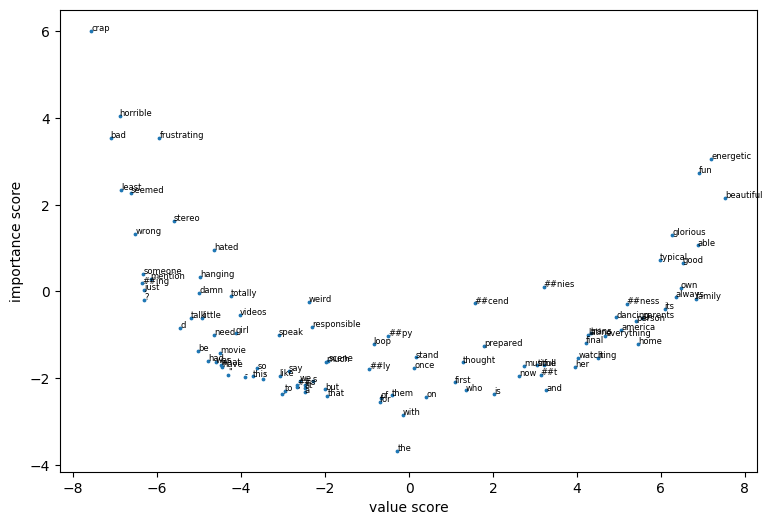

In [13]:
# First scatter plot
tok_list = []
import matplotlib.pyplot as plt
for k, v in slalom_weights.items():
    tok_str = k
    tok_str = tok_str.replace("Ġ", "")
    tok_list.append(tok_str)
    plt.scatter([v[1]], [v[0]], 3, c="tab:blue")
    plt.annotate(tok_str, xy=(v[1], v[0]), fontsize=6)
plt.xlabel("value score")
plt.ylabel("importance score")
plt.gcf().set_size_inches(9,6)
#plt.gcf().savefig(f"figures/E_scatter_id{sample_id}_{run}.pdf")
#plt.plot([-2, 2], [-2,2], "--k")

In [14]:
print_toks = {(2, "bert"):
                  (["fun", "bad", "crap", "horrible", "someone", "the", "beautiful", "energetic", "fun", "for", "this", "person", "family"], 0.5, 0.4),
              (2, "gpt"):
                  (["frustrating", "bad", "crappy", "-rible", "the", "beautiful", "energetic", "hated", "for", "person", "family"], 3.2, 0.2)}

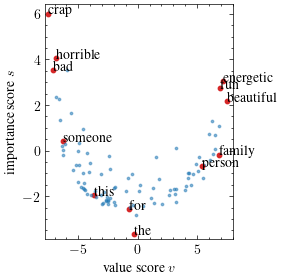

In [18]:
# First scatter plot

model_type = "gpt" if "gpt" in run_long else "bert"
sample_id=2
import matplotlib.pyplot as plt
plt.style.use('./figures/matplot.mplstyle')
max_v = max([v[1] for v in slalom_weights.values()])
max_s = max([v[0] for v in slalom_weights.values()])
min_v = min([v[1] for v in slalom_weights.values()])
min_s = min([v[0] for v in slalom_weights.values()])
for k, v in slalom_weights.items():
    tok_str = k
    if "gpt" in run_long:
        if tok_str[0] != "Ġ":
            tok_str = "-" + tok_str
    tok_str = tok_str.replace("Ġ", "")

    if tok_str in print_toks[(sample_id, model_type)][0]:
        plt.scatter([v[1]], [v[0]], 10, c="tab:red")
        plt.annotate(tok_str, xy=(v[1], v[0]))
    else:
        plt.scatter([v[1]], [v[0]], 3, c="tab:blue", alpha=0.5)
plt.xlim([min_v-0.2, max_v+print_toks[(sample_id, model_type)][1]])
plt.ylim([min_s-0.2, max_s+print_toks[(sample_id, model_type)][2]])
plt.grid(None)
plt.xlabel(r"value score $v$")
plt.ylabel(r"importance score $s$")
plt.gcf().set_size_inches(3,3)
plt.tight_layout()
#plt.gcf().savefig(f"figures/f_{run}_{sample_id}_scatter.pdf")

## Text Highlight plots

In [19]:

from matplotlib.colors import Normalize
import matplotlib as mpl
def visualize_attention(att_mat, decoded_tokens, start_pos_y, max_len=50, vmax=5):
    '''
    s_pos: from which token the attention should be visualized (usually the CLS token)
    start_pos_y: for visalizing multiple rows
    max_len: how many tokens should be visualized
    '''
    # average over all heads
    #att_mat = att_mat.sum(axis=1)/att_mat.shape[1]
    #cls_atts = np.flip(att_mat[:,s_pos], axis=0)
    cls_atts = att_mat[:max_len]


    fig, ax = plt.subplots(figsize=(7, 4.9))
    rend = fig.canvas.get_renderer()
    pos_x = 15
    max_x = 500
    pos_y = start_pos_y
    whitespace = 10
    norm = Normalize(vmin=-vmax, vmax=vmax)
    #cmap = plt.cm.YlOrRd
    #cmap = plt.cm.bwr
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red","white","green"])
    plt.xlim([0, max_x+50])
    for token, att in zip(decoded_tokens, cls_atts):
        bb = dict(boxstyle="square, pad=0.2", fc=cmap(norm(att)), alpha=0.6)
        text = plt.text(pos_x, pos_y, token.replace("##", "").replace("Ġ", ""), color='black', bbox=bb, fontsize=12)
        pos_x += text.get_window_extent(renderer=rend).width + whitespace

        if pos_x > max_x:
            pos_x = 15
            pos_y -= 25
    plt.ylim([pos_y-40, start_pos_y+15])
    #cax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Adjust these values as needed
    #cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    #cb.set_label('Attention Score', fontsize=10)
    #cb.ax.tick_params(axis='both', labelsize=10)


    ax.set_facecolor('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    plt.show()
    return fig, ax

In [21]:
from slalom_explanations import SLALOMLocalExplanantions
myslalomeff = SLALOMLocalExplanantions(model_obj.model, device="cuda:3", sgd_lr= 1e-2, sgd_epochs= 50, modes = ["lin"], n_samples = 5000, seq_len= 2, pad_token_id=(50256 if "gpt" in run_long else 0))

In [22]:
myslalomeff = myslalomeff.get_signed_importance_for_tokens(inp_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.75it/s]


In [23]:
myslalomeff

array([[-5.3514546e-01, -1.1118921e+00, -8.9287746e-01, -5.5634016e-01,
        -3.1538901e+02, -3.3057910e-01,  1.7048665e+00, -7.5638786e+01,
         2.3109033e+02,  3.5051206e-01, -2.9575846e-01, -8.9287746e-01,
        -3.0690653e+00,  5.4609424e-01, -2.7916992e-01, -8.2507980e-01,
        -2.4992447e-01,  1.2667639e+01,  5.8164275e-01, -3.3057910e-01,
        -2.9575846e-01, -1.8867482e-01, -9.2874512e+01,  2.1148367e-01,
        -2.9575846e-01, -4.2040798e-01, -2.2736471e+00, -1.2409784e+00,
         1.9754360e+01, -2.7916992e-01, -7.1770310e-02,  1.0566075e+00,
        -3.3057910e-01, -2.9603928e-01, -2.8533748e-01, -2.9575846e-01,
        -8.9287746e-01, -2.6978104e+01, -3.3057910e-01,  1.1150370e-01,
        -2.8533748e-01, -7.7884411e-03, -1.7296060e+00, -3.1884730e-01,
        -9.4240513e+00, -5.4804735e+00,  1.0566075e+00, -8.9287746e-01,
        -4.4608930e-01,  9.5326340e-01, -7.6942974e-01,  2.4097617e+00,
        -4.2040798e-01, -2.3996904e-01,  1.0161973e+02,  3.47742

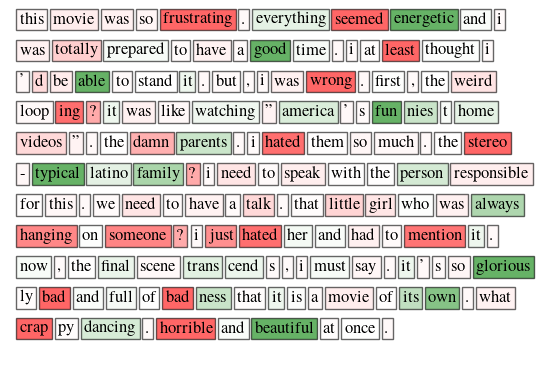

In [24]:
f, ax = visualize_attention(myslalomeff.flatten(), data, start_pos_y=500, max_len=200, vmax=10)

In [25]:
#f.savefig(f"figures/f_highlight_{run}_{sample_id}.pdf")